In [1]:
import math
import os
import time
import tempfile, uuid
from collections import defaultdict
import xml.etree.ElementTree as ET
from xml.dom import minidom

import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pathlib import Path
import pdb
import h5py
import math
import matplotlib.pyplot as plt


In [2]:
import pixelengine as pixelengine
import softwarerendercontext as softwarerendercontext
import softwarerenderbackend as softwarerenderbackend


render_context = softwarerendercontext.SoftwareRenderContext()
render_backend = softwarerenderbackend.SoftwareRenderBackend()
pe = pixelengine.PixelEngine(render_backend, render_context)

In [3]:
class Contour_Checking_fn(object):
        # Defining __call__ method 
        def __call__(self, pt): 
                raise NotImplementedError

class isInContourV1(Contour_Checking_fn):
        def __init__(self, contour):
                self.cont = contour

        def __call__(self, pt): 
                return 1 if cv2.pointPolygonTest(self.cont, pt, False) >= 0 else 0

class isInContourV2(Contour_Checking_fn):
        def __init__(self, contour, patch_size):
                self.cont = contour
                self.patch_size = patch_size

        def __call__(self, pt): 
                return 1 if cv2.pointPolygonTest(self.cont, (pt[0]+self.patch_size//2, pt[1]+self.patch_size//2), False) >= 0 else 0

class isInContourV3_Easy(Contour_Checking_fn):
        def __init__(self, contour, patch_size, center_shift=0.5):
                self.cont = contour
                self.patch_size = patch_size
                self.shift = int(patch_size//2*center_shift)
        def __call__(self, pt): 
                center = (pt[0]+self.patch_size//2, pt[1]+self.patch_size//2)
                if self.shift > 0:
                        all_points = [(center[0]-self.shift, center[1]-self.shift),
                                                  (center[0]+self.shift, center[1]+self.shift),
                                                  (center[0]+self.shift, center[1]-self.shift),
                                                  (center[0]-self.shift, center[1]+self.shift)
                                                  ]
                else:
                        all_points = [center]
                
                #print('all points to be checked:', all_points)
                for points in all_points:
                    
                    if cv2.pointPolygonTest(self.cont, points, False) >= 0:
                        return 1
                return 0

class isInContourV3_Hard(Contour_Checking_fn):
        def __init__(self, contour, patch_size, center_shift=0.5):
                self.cont = contour
                self.patch_size = patch_size
                self.shift = int(patch_size//2*center_shift)
        def __call__(self, pt):
                center = (pt[0]+self.patch_size//2, pt[1]+self.patch_size//2)
                #print(center)
                if self.shift > 0:
                        all_points = [(center[0]-self.shift, center[1]-self.shift),
                                                  (center[0]+self.shift, center[1]+self.shift),
                                                  (center[0]+self.shift, center[1]-self.shift),
                                                  (center[0]-self.shift, center[1]+self.shift)
                                                  ]
                else:
                        all_points = [center]
                #print(all_points)
                for points in all_points:
                        if cv2.pointPolygonTest(self.cont, points, False) < 0:
                                return 0
                return 1


In [4]:
def savePatchIter_bag_hdf5(patch):
    x, y, cont_idx, patch_level, downsample, downsampled_level_dim, level_dim, img_patch, name, save_path= tuple(patch.values())
    img_patch = np.array(img_patch)[np.newaxis,...]
    img_shape = img_patch.shape

    file_path = os.path.join(save_path, name)+'.h5'
    file = h5py.File(file_path, "a")

    dset = file['imgs']
    dset.resize(len(dset) + img_shape[0], axis=0)
    dset[-img_shape[0]:] = img_patch

    if 'coords' in file:
        coord_dset = file['coords']
        coord_dset.resize(len(coord_dset) + img_shape[0], axis=0)
        coord_dset[-img_shape[0]:] = (x,y)

    file.close()

def save_hdf5(output_path, asset_dict, attr_dict= None, mode='a'):
    file = h5py.File(output_path, mode)
    for key, val in asset_dict.items():
        data_shape = val.shape
        if key not in file:
            data_type = val.dtype
            chunk_shape = (1, ) + data_shape[1:]
            maxshape = (None, ) + data_shape[1:]
            dset = file.create_dataset(key, shape=data_shape, maxshape=maxshape, chunks=chunk_shape, dtype=data_type)
            dset[:] = val
            if attr_dict is not None:
                if key in attr_dict.keys():
                    for attr_key, attr_val in attr_dict[key].items():
                        dset.attrs[attr_key] = attr_val
        else:
            dset = file[key]
            dset.resize(len(dset) + data_shape[0], axis=0)
            dset[-data_shape[0]:] = val
    file.close()
    return output_path

def initialize_hdf5_bag(first_patch, save_coord=False):
    x, y, cont_idx, patch_level, downsample, downsampled_level_dim, level_dim, img_patch, name, save_path = tuple(first_patch.values())
    file_path = os.path.join(save_path, name)+'.h5'
    file = h5py.File(file_path, "w")
    img_patch = np.array(img_patch)[np.newaxis,...]
    dtype = img_patch.dtype

    # Initialize a resizable dataset to hold the output
    img_shape = img_patch.shape
    maxshape = (None,) + img_shape[1:] #maximum dimensions up to which dataset maybe resized (None means unlimited)
    dset = file.create_dataset('imgs', 
                                shape=img_shape, maxshape=maxshape,  chunks=img_shape, dtype=dtype)

    dset[:] = img_patch
    dset.attrs['patch_level'] = patch_level
    dset.attrs['wsi_name'] = name
    dset.attrs['downsample'] = downsample
    dset.attrs['level_dim'] = level_dim
    dset.attrs['downsampled_level_dim'] = downsampled_level_dim

    if save_coord:
        coord_dset = file.create_dataset('coords', shape=(1, 2), maxshape=(None, 2), chunks=(1, 2), dtype=np.int32)
        coord_dset[:] = (x,y)

    file.close()
    return file_path

def DrawMapFromCoords(canvas, WSI_object, coords, patch_size, vis_level, indices=None, verbose=1, 
                      draw_grid=True):
    dims = WSI_object.level_dimensions[0]
    w0, h0 = dims[1]-dims[0] + 1, dims[3]-dims[2]+ 1

    img_lvl = len(WSI_object.level_dimensions) -1
    if img_lvl >= vis_level:
        loc1, w, loc2, h = WSI_object.level_dimensions[vis_level]
        w_vis, h_vis = w - loc1 + 1, h - loc2 + 1
    else:
        loc1, w, loc2, h = WSI_object.level_dimensions[img_lvl]
        w_old, h_old = w-loc1 + 1, h- loc2 + 1
        lev_diff = vis_level - img_lvl
        w_vis = int(w_old // 2 ** lev_diff)
        h_vis = int(h_old // 2 ** lev_diff)
    
    downsamples = w0// w_vis, h0// h_vis 
    if indices is None:
        indices = np.arange(len(coords))
    total = len(indices)
    if verbose > 0:
        ten_percent_chunk = math.ceil(total * 0.1)
        
    patch_size = tuple(np.ceil((np.array(patch_size)/np.array(downsamples))).astype(np.int32))
    #print('downscaled patch size: {}x{}'.format(patch_size[0], patch_size[1]))
    for idx in range(total):
        if verbose > 0:
            if idx % ten_percent_chunk == 0:
                print('progress: {}/{} stitched'.format(idx, total))
        
        patch_id = indices[idx]
        coord = coords[patch_id]
        patch_request = RegionRequest(tuple(coord), vis_level, patch_size)
        patch = np.array(WSI_object.read_region(patch_request))
        coord = np.ceil(coord / downsamples).astype(np.int32) 
        canvas_crop_shape = canvas[coord[1]:coord[1]+patch_size[1], coord[0]:coord[0]+patch_size[0], :3].shape[:2]
        canvas[coord[1]:coord[1]+patch_size[1], coord[0]:coord[0]+patch_size[0], :3] = patch[:canvas_crop_shape[0], :canvas_crop_shape[1], :]
        if draw_grid:
            DrawGrid(canvas, coord, patch_size)

    return Image.fromarray(canvas)


def StitchCoords(hdf5_file_path, WSI_object, downscale=16, draw_grid=False, bg_color=(0, 0, 0), alpha=-1):
    vis_level = int(get_best_level_for_downsample(downscale))
    
    file = h5py.File(hdf5_file_path, 'r')
    dset = file['coords']
    coords = dset[:]

    #dimensions at level zero 
    loc1, w, loc2, h = WSI_object.level_dimensions[0]
    w0, h0 = w - loc1 + 1, h- loc2 + 1
    print('start stitching {}'.format(dset.attrs['name']))
    print('original size: {} x {}'.format(w0, h0))
    
    patch_size = dset.attrs['patch_size']
    patch_level = dset.attrs['patch_level']
    #print('patch size: {}x{} patch level: {}'.format(patch_size, patch_size, patch_level))
    

    img_lvl = len(WSI_object.level_dimensions) -1
    if img_lvl >= vis_level:
        loc1, w, loc2, h = WSI_object.level_dimensions[vis_level]
        w_vis, h_vis = w - loc1 + 1, h - loc2 + 1
    else:
        loc1, w, loc2, h = WSI_object.level_dimensions[img_lvl]
        w_old, h_old = w-loc1 + 1, h- loc2 + 1
        lev_diff = vis_level - img_lvl
        w_vis = int(w_old // 2 ** lev_diff)
        h_vis = int(h_old // 2 ** lev_diff)
    
    print('downscaled size for stiching: {} x {}'.format(w_vis, h_vis))
    print('number of patches: {}'.format(len(coords)))


    #compute ref patch_size at patch_level
    if img_lvl >= patch_level:
        loc1, w, loc2, h = WSI_object.level_dimensions[patch_level]
        w_patch, h_patch = w - loc1 + 1, h - loc2 + 1
    else:
        loc1, w, loc2, h = WSI_object.level_dimensions[img_lvl]
        w_old, h_old = w-loc1 + 1, h- loc2 + 1
        lev_diff = patch_level - img_lvl
        w_patch = int(w_old // 2 ** lev_diff)
        h_patch = int(h_old // 2 ** lev_diff)
    
    downsample = (w0//w_patch, h0//h_patch)
    patch_size = tuple((np.array((patch_size, patch_size)) *downsample).astype(np.int32))
    #print('ref patch size: {}'.format(patch_size))
    
    
    if w_vis*h_vis > Image.MAX_IMAGE_PIXELS: 
        raise Image.DecompressionBombError("Visualization Downscale %d is too large" % downscale)
    
    if alpha < 0 or alpha == -1:
        heatmap = Image.new(size=(w_vis,h_vis), mode="RGB", color=bg_color)
    else:
        heatmap = Image.new(size=(w_vis,h_vis), mode="RGBA", color=bg_color + (int(255 * alpha),))
    heatmap = np.array(heatmap)
    heatmap = DrawMapFromCoords(heatmap, WSI_object, coords, patch_size, vis_level, indices=None, draw_grid=draw_grid )
    
    file.close()
    return heatmap

    

In [5]:
def get_best_level_for_downsample(downsample):
    best_level = int(math.log(downsample, 2))
    return best_level


def segment(WSI_object, seg_params, filter_params):
        start_time = time.time()
        # Segment
        WSI_object.segmentTissue(**seg_params, filter_params=filter_params)
        seg_time_elapsed = time.time() - start_time
        return WSI_object, seg_time_elapsed
    
def patching(save_dir, WSI_object, **kwargs):
    # Start Patch Timer
    start_time = time.time()
    # Patch
    file_path = WSI_object.createPatches_bag_hdf5(save_dir,**kwargs, save_coord=True)
    # Stop Patch Timer
    patch_time_elapsed = time.time() - start_time
    return file_path, patch_time_elapsed

def stitching(file_path, downscale = 64):
    start = time.time()
    heatmap = StitchPatches(file_path, downscale=downscale, bg_color=(0,0,0), alpha=-1, draw_grid=False)
    total_time = time.time() - start
    
    return heatmap, total_time


In [6]:
def DrawMap(canvas, patch_dset, coords, patch_size, indices=None, verbose=1, draw_grid=True):
    if indices is None:
        indices = np.arange(len(coords))
    total = len(indices)
    if verbose > 0:
        ten_percent_chunk = math.ceil(total * 0.1)
        print('\nstart stitching {}.syntax ...'.format(patch_dset.attrs['wsi_name']))

    for idx in range(total):
        if verbose > 0:
            if idx % ten_percent_chunk == 0:
                print('progress: {}/{} stitched'.format(idx, total))

        patch_id = indices[idx]
        patch = patch_dset[patch_id]
        patch = cv2.resize(patch, patch_size)
        coord = coords[patch_id]
        canvas_crop_shape = canvas[coord[1]:coord[1]+patch_size[1], coord[0]:coord[0]+patch_size[0], :3].shape[:2]
        canvas[coord[1]:coord[1]+patch_size[1], coord[0]:coord[0]+patch_size[0], :3] = patch[:canvas_crop_shape[0], :canvas_crop_shape[1], :]
        if draw_grid:
            DrawGrid(canvas, coord, patch_size)

    return Image.fromarray(canvas)

def StitchPatches(h5py_file_path, downscale= 64, draw_grid=False, bg_color=(0,0,0), alpha=-1):
    file = h5py.File(h5py_file_path, 'r')
    dest = file['imgs']
    coords = file['coords'][:]

    if 'downsampled_level_dim' in dest.attrs.keys():
        w, h = dest.attrs['downsampled_level_dim']
    else:
        w, h = dset.attrs['level_dim']

    w = w // downscale
    h = h //downscale
    coords = (coords / downscale).astype(np.int32)
    img_shape = dest[0].shape
    print('number of patches: {}, patch shape: {}'.format(len(dest), img_shape))
    downscaled_shape = (img_shape[1] // downscale, img_shape[0] // downscale)

    if w*h > Image.MAX_IMAGE_PIXELS:
        raise Image.DecompressionBombError("Visualization Downscale %d is too large" % downscale)

    if alpha < 0 or alpha == -1:
        heatmap = Image.new(size=(w,h), mode = 'RGB', color = bg_color)
    else:
         heatmap = Image.new(size=(w,h), mode="RGBA", color=bg_color + (int(255 * alpha),))

    heatmap = np.array(heatmap)
    heatmap = DrawMap(heatmap, dest, coords, downscaled_shape, indices=None, draw_grid=draw_grid)

    file.close()
    return heatmap

def get_cache_folder():
    cache_path = os.path.join(tempfile.gettempdir(), 'cache')
    os.makedirs(cache_path, exist_ok=True)
    return cache_path

class RegionRequest:
    def __init__(self, loc, level, size):
        """
        Args:
            loc (int, int): position of the top left pixel of the region
            level (int): the level of the requested region
            size (int, int): size of the region to be read
        """
        self._loc = loc
        self._level = level
        self._size = size

    @property
    def loc(self):
        return self._loc

    @property
    def level(self):
        return self._level

    @property
    def size(self):
        return self._size

class WholeSlideImage(object):
    def __init__(self, path, hdf5_file=None):
        self.path = path
        self.pe = pe
        self.name = ".".join(path.split("/")[-1].split('.')[:-1])
        cache_folder = get_cache_folder()
        self.pe_slide_uuid = str(uuid.uuid4())
        self.pe[self.pe_slide_uuid].open(path, '', 'r', cache_folder)
        self._view = self.pe[self.pe_slide_uuid].SourceView()
        levels = self.pe[self.pe_slide_uuid].numLevels() + 1
        self.level_dimensions = [self._get_valid_range(l) for l in range(levels)]
              
        
        self.contours_tissue = None
        self.contours_tumor = None
        self.seg_level = None
        self.hdf5_file = hdf5_file
        
        
    def getOpenSlide(self):
        self.wsi = pe['in'].open(self.path)
        return self.wsi

    def __del__(self):
        if hasattr(self, 'pe'):
            self.pe[self.pe_slide_uuid].close()

    def _get_valid_range(self, level):
        """Get the valid range at the specified level.
        The valid range corresponds to the dimensionRanges of the given
        level clipped to the data envelopes (we assume that the regions
        between envelopes are also valid).
        """
        dim_ranges = self._view.dimensionRanges(level)

        start_x, end_x = dim_ranges[0][0], dim_ranges[0][2]
        start_y, end_y = dim_ranges[1][0], dim_ranges[1][2]

        envelope_polys = self._view.dataEnvelopes(0).asRectangles()
        min_x, min_y = min([e[0] for e in envelope_polys]), min([e[2] for e in envelope_polys])
        max_x, max_y = max([e[1] for e in envelope_polys]), max([e[3] for e in envelope_polys])
        return (int(max(min_x, start_x) / 2 ** level), int(min(max_x, end_x) / 2 ** level),
                int(max(min_y, start_y) / 2 ** level), int(min(max_y, end_y) / 2 ** level))

    def read_region(self, region_request):
        """Read a region from the slide at the specified level.
        Args:
            region_request (RegionRequest): the region to be requested
        Returns:
            numpy.core.ndarray: ndarray with the region extracted from the image
        """
        return next(self.read_regions([region_request]))[1]

    def read_regions(self, region_requests):
        """Read a part of the slide and returns as numpy array.
        Pixels not provided by the PixelEngine are padded with 255
        Args:
            region_requests (collections.Iterable[RegionRequest]): the regions to be requested
        Returns:
            collections.Generator[(RegionRequest, numpy.core.ndarray)]: with the region extracted from the image
        """
        view_ranges = defaultdict(list)
        valid_requests = defaultdict(list)
        for req in region_requests:
            x_min, y_min = req.loc
            width, height = req.size
            x_max = x_min + width - 1
            y_max = y_min + height - 1

            x_min *= 2 ** req.level
            x_max *= 2 ** req.level
            y_min *= 2 ** req.level
            y_max *= 2 ** req.level

            view_range = (x_min, x_max, y_min, y_max, req.level)
            view_ranges[req.level].append(view_range)
            valid_requests[req.level].append(req)

        regions_lut = dict()

        for level, vr in view_ranges.items():
            regions = self._view.requestRegions(vr,
                                                backgroundColor=[255, 255, 255, 255],
                                                enableAsyncRendering=True,
                                                dataEnvelopes=self._view.dataEnvelopes(level))
            regions_lut.update({region: req for req, region in zip(valid_requests[level], regions)})
            del regions


        del view_ranges
        del valid_requests

        while regions_lut:
            regions_ready = self.pe.waitAny(list(regions_lut.keys()))
            for region in regions_ready:
                req = regions_lut.pop(region)
                try:
                    size = (req.size[1], req.size[0], 3)
                    patch = np.empty(size, dtype=np.uint8)

                    region.get(patch)
                    yield req, patch
                except Exception as ex:
                    yield req, ex


    def initXML(self, xml_path):
        def _createContour(coord_list):
            return np.array([[[int(float(coord.attributes['X'].value)), 
                               int(float(coord.attributes['Y'].value))]] for coord in coord_list], dtype = 'int32')

        xmldoc = minidom.parse(xml_path)
        annotations = [anno.getElementsByTagName('Coordinate') for anno in xmldoc.getElementsByTagName('Annotation')]
        self.contours_tumor  = [_createContour(coord_list) for coord_list in annotations]
        self.contours_tumor = sorted(self.contours_tumor, key=cv2.contourArea, reverse=True)

    def initTxt(self,annot_path):
        def _create_contours_from_dict(annot):
            all_cnts = []
            for idx, annot_group in enumerate(annot):
                contour_group = annot_group['coordinates']
                if annot_group['type'] == 'Polygon':
                    for idx, contour in enumerate(contour_group):
                        contour = np.array(contour).astype(np.int32).reshape(-1,1,2)
                        all_cnts.append(contour) 

                else:
                    for idx, sgmt_group in enumerate(contour_group):
                        contour = []
                        for sgmt in sgmt_group:
                            contour.extend(sgmt)
                        contour = np.array(contour).astype(np.int32).reshape(-1,1,2)    
                        all_cnts.append(contour) 

            return all_cnts
        with open(annot_path, "r") as f:
            annot = f.read()
            annot = eval(annot)
        self.contours_tumor  = _create_contours_from_dict(annot)
        self.contours_tumor = sorted(self.contours_tumor, key=cv2.contourArea, reverse=True)

    def initSegmentation(self, mask_file):
        # load segmentation results from pickle file
        import pickle
        asset_dict = load_pkl(mask_file)
        self.holes_tissue = asset_dict['holes']
        self.contours_tissue = asset_dict['tissue']

    def saveSegmentation(self, mask_file):
        # save segmentation results using pickle
        asset_dict = {'holes': self.holes_tissue, 'tissue': self.contours_tissue}
        save_pkl(mask_file, asset_dict) 

    def segmentTissue(self, seg_level=0, sthresh=10, sthresh_up = 255, mthresh=7, close = 0, use_otsu=False, 
                            filter_params={'a':50}, ref_patch_size = 32, exclude_ids=[], keep_ids=[]):
        """
            Segment the tissue via HSV -> Median thresholding -> Binary threshold
        """
        
        def _filter_contours(contours, hierarchy, filter_params):
            """
                Filter contours by: area.
            """
            filtered = []
            # find indices of foreground contours (parent == -1)
            hierarchy_1 = np.flatnonzero(hierarchy[:,1] == -1)
            all_holes = []
            #loop through froeground contour indices
            for cont_idx in hierarchy_1:
                cont = contours[cont_idx]
                # indices of holes contained in this contour (children of parent contour)
                holes = np.flatnonzero(hierarchy[:, 1] == cont_idx)
                
                # take contour area (includes holes)
                a = cv2.contourArea(cont)
                
                hole_areas = [cv2.contourArea(contours[hole_idx]) for hole_idx in holes]
               
                # actual area of foreground contour region
                a = a - np.array(hole_areas).sum()
                if a == 0: continue
                if tuple((filter_params['a_t'],)) < tuple((a,)): 
                    filtered.append(cont_idx)
                    all_holes.append(holes)
            
            foreground_contours = [contours[cont_idx] for cont_idx in filtered]
            hole_contours = []

            for hole_ids in all_holes:
                unfiltered_holes = [contours[idx] for idx in hole_ids ]
                unfilered_holes = sorted(unfiltered_holes, key=cv2.contourArea, reverse=True)
                unfilered_holes = unfilered_holes[:filter_params['max_n_holes']]
                filtered_holes = []
                
                for hole in unfilered_holes:
                    if cv2.contourArea(hole) > filter_params['a_h']:
                        filtered_holes.append(hole)
                hole_contours.append(filtered_holes)
            return foreground_contours, hole_contours
        
        seg_level = int(seg_level)
             
        #get size of image at the segmentation level given
        dim = self.level_dimensions[seg_level]
        w = dim[1]-dim[0]+1
        h = dim[3]-dim[2]+1
        loc =(dim[0], dim[2])
        patch_request = RegionRequest(loc, seg_level, (w,h))
        
        img = np.array(self.read_region(patch_request))
        img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)  # Convert to HSV space
        img_med = cv2.medianBlur(img_hsv[:,:,1], mthresh)  # Apply median blurring 
        # Thresholding
        if use_otsu:
            _, img_otsu = cv2.threshold(img_med, 0, sthresh_up, cv2.THRESH_OTSU+cv2.THRESH_BINARY)
        else:
            _, img_otsu = cv2.threshold(img_med, sthresh, sthresh_up, cv2.THRESH_BINARY)
        
        # Morphological closing
        if close > 0:
            kernel = np.ones((close, close), np.uint8)
            img_otsu = cv2.morphologyEx(img_otsu, cv2.MORPH_CLOSE, kernel)  
        
        fig = plt.figure()
        f, axarr = plt.subplots(1,2) 
        axarr[0].imshow(img)
        axarr[1].imshow(img_otsu)
               
        scale = tuple(ele1 // ele2 for ele1, ele2 in zip(self.level_dimensions[0], (loc[0], w, loc[1], h)))
        scale =(scale[1], scale[3])
        scaled_ref_patch_area = int(ref_patch_size**2 / (scale[0] * scale[1]))
        
        filter_params['a_t'] = filter_params['a_t'] * scaled_ref_patch_area
        filter_params['a_h'] = filter_params['a_h'] * scaled_ref_patch_area

        # Find and filter contours
        contours, hierarchy = cv2.findContours(img_otsu, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE) # Find contours
        hierarchy = np.squeeze(hierarchy, axis=(0,))[:,2:]
        
        if filter_params: foreground_contours, hole_contours = _filter_contours(contours, hierarchy, filter_params)  # Necessary for filtering out artifacts
        self.contours_tissue = self.scaleContourDim(foreground_contours, scale)
        self.holes_tissue = self.scaleHolesDim(hole_contours, scale)  
     
        
#         if len(keep_ids) > 0:
#             contour_ids = set(keep_ids) - set(exclude_ids)
#         else:
#             contour_ids = set(np.arange(len(self.contours_tissue))) - set(exclude_ids)
        
#         self.contours_tissue = [self.contours_tissue[i] for i in contour_ids]
#         self.holes_tissue = [self.holes_tissue[i] for i in contour_ids]
#         print(contour_ids)
    
    def visWSI(self, vis_level=0, color = (0,255,0), hole_color = (0,0,255), annot_color=(255,0,0), 
                    line_thickness=10, max_size=None, top_left=None, bot_right=None, custom_downsample=1,
                  view_slide_only=False,number_contours=False, seg_display=True, annot_display=True):  
        
        lvl = int(vis_level)
        downsample = tuple(ele1 // ele2 for ele1, ele2 in zip(self.level_dimensions[0], self.level_dimensions[lvl]))
        downsample = (downsample[1], downsample[3])

        scale = [1/downsample[0], 1/downsample[1]] 
        
        if top_left is not None and bot_right is not None:
            top_left = tuple(top_left)
            bot_right = tuple(bot_right)
            w, h = tuple((np.array(bot_right) * scale).astype(int) - (np.array(top_left) * scale).astype(int))
            region_size = (w, h)
        else:
            top_left = (0, 0)
            dim = self.level_dimensions[lvl]
            region_size = (dim[1]-dim[0]+1, dim[3]-dim[2]+1)

        patch_request = RegionRequest(top_left, lvl, region_size)
        img = np.array(self.read_region(patch_request))
        
        if not view_slide_only:
            offset = tuple(-(np.array(top_left) * scale).astype(int))
            line_thickness = int(line_thickness * math.sqrt(scale[0] * scale[1]))
            if self.contours_tissue is not None and seg_display:
                if not number_contours:
                    cv2.drawContours(img, self.scaleContourDim(self.contours_tissue, scale),
                                     -1, color, line_thickness, lineType=cv2.LINE_8, offset=offset)

                else: # add numbering to each contour
                    for idx, cont in enumerate(self.contours_tissue):
                        contour = np.array(self.scaleContourDim(cont, scale))
                        M = cv2.moments(contour)
                        cX = int(M["m10"] / (M["m00"] + 1e-9))
                        cY = int(M["m01"] / (M["m00"] + 1e-9))
                        # draw the contour and put text next to center
                        cv2.drawContours(np.array(img),  [contour], -1, color, line_thickness, lineType=cv2.LINE_8, offset=offset)
                        cv2.putText(np.array(img), "{}".format(idx), (cX, cY),
                                cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 10)

                for holes in self.holes_tissue:
                    cv2.drawContours(np.array(img), self.scaleContourDim(holes, scale),
                                     -1, hole_color, line_thickness, lineType=cv2.LINE_8)

            if self.contours_tumor is not None and annot_display:
                cv2.drawContours(np.array(img), self.scaleContourDim(self.contours_tumor, scale),
                                 -1, annot_color, line_thickness, lineType=cv2.LINE_8, offset=offset)

        
        img = Image.fromarray(img)
        w, h = img.size
        if custom_downsample > 1:
            img = img.resize((int(w/custom_downsample), int(h/custom_downsample)))

        if max_size is not None and (w > max_size or h > max_size):
            resizeFactor = max_size/w if w > h else max_size/h
            img = img.resize((int(w*resizeFactor), int(h*resizeFactor)))
       
        return img
    
    def createPatches_bag_hdf5(self, save_path, patch_level=0, patch_size=256, step_size=256, save_coord=True, **kwargs):
        contours = self.contours_tissue
        contour_holes = self.holes_tissue
        
        print('\nCreating patches for {}.isyntax ...\n'.format(self.name))
        elapsed = time.time()
        for idx, cont in enumerate(contours):
            patch_gen = self._getPatchGenerator(cont, idx, patch_level, save_path, patch_size, step_size, **kwargs)
            
            if self.hdf5_file is None:
                try:
                    first_patch = next(patch_gen)

                # empty contour, continue
                except StopIteration:
                    continue

                file_path = initialize_hdf5_bag(first_patch, save_coord=save_coord)
                self.hdf5_file = file_path

            for patch in patch_gen:
                savePatchIter_bag_hdf5(patch)

        return self.hdf5_file 
    
    def _getPatchGenerator(self, cont, cont_idx, patch_level, save_path, patch_size=256, step_size=256, custom_downsample=1,
        white_black=True, white_thresh=15, black_thresh=40, contour_fn='four_pt', use_padding=True): 
        
        lvl = patch_level
        w = self.level_dimensions[lvl][1] - self.level_dimensions[lvl][0] + 1  #
        h = self.level_dimensions[lvl][3] - self.level_dimensions[lvl][2] + 1  #
        
        start_x, start_y, w, h = cv2.boundingRect(cont) if cont is not None else (0, 0, w,h)
        print("Bounding Box:", start_x, start_y, w, h)
        print("Contour Area:", cv2.contourArea(cont))
        #print('custom downsample:', custom_downsample)
        if custom_downsample > 1:
            assert custom_downsample == 2 
            # the target size is what's specified by patch_size
            target_patch_size = patch_size 
            # the actual patches that we want to take is 2 * target_size for each dimension
            patch_size = target_patch_size * 2 
            # similarly, the step size is 2 * what's specified
            step_size = step_size * 2       
        if patch_level == 0:
            patch_downsample =(1, 1) 
        else:
            downsample = tuple(ele1 // ele2 for ele1, ele2 in zip(self.level_dimensions[0], self.level_dimensions[patch_level]))
            patch_downsample = (downsample[1], downsample[3])

        ref_patch_size = (patch_size*patch_downsample[0], patch_size*patch_downsample[1])
        # step sizes to take at levl 0
        step_size_x = step_size * patch_downsample[0]
        step_size_y = step_size * patch_downsample[1]
        
        if isinstance(contour_fn, str):
            if contour_fn == 'four_pt':
                cont_check_fn = isInContourV3_Easy(contour=cont, patch_size=ref_patch_size[0], center_shift=0.5)
            elif contour_fn == 'four_pt_hard':
                cont_check_fn = isInContourV3_Hard(contour=cont, patch_size=ref_patch_size[0], center_shift=0.5)
            elif contour_fn == 'center':
                cont_check_fn = isInContourV2(contour=cont, patch_size=ref_patch_size[0])
            elif contour_fn == 'basic':
                cont_check_fn = isInContourV1(contour=cont)
            else:
                raise NotImplementedError
        else:
            assert isinstance(contour_fn, Contour_Checking_fn)
            cont_check_fn = contour_fn
        
        
        #image size at level zero
        img_w = self.level_dimensions[0][1] - self.level_dimensions[0][0] + 1
        img_h = self.level_dimensions[0][3] - self.level_dimensions[0][2] + 1

        if use_padding:
            stop_y = start_y+h
            stop_x = start_x+w
        else:
            stop_y = min(start_y+h, img_h-ref_patch_size[1])
            stop_x = min(start_x+w, img_w-ref_patch_size[0])

        count = 0
        for y in range(start_y, stop_y, step_size_y):
            for x in range(start_x, stop_x, step_size_x):
                
#                 if not self.isInContours(cont_check_fn, cont, (x,y), self.holes_tissue[cont_idx]): #point not inside contour and its associated holes
#                     continue    
                
                count+=1
                patch_request = RegionRequest((x,y), patch_level, (patch_size, patch_size))
                img = self.read_region(patch_request)
                img = np.array(self.read_region(patch_request))
                               
                #patch_PIL = Image.fromarray(img.astype(np.uint8))
                patch_PIL = Image.fromarray(img)
                plt.imshow(patch_PIL)
                if custom_downsample > 1:
                    patch_PIL = patch_PIL.resize((target_patch_size, target_patch_size))
               
               
                #print(np.all(np.mean(patch_PIL, axis = (0,1))))
#                 if white_black:
#                     if self.isBlackPatch(np.array(patch_PIL), rgbThresh=black_thresh) or self.isWhitePatch(np.array(patch_PIL), satThresh=white_thresh): 
#                         continue

                downsampled_dim = tuple(np.array(self.level_dimensions[patch_level])//custom_downsample)
                downsample_level_dim = tuple((downsampled_dim[1], downsampled_dim[3]))
                
                level_dim = self.level_dimensions[patch_level]
                level_dim = tuple((level_dim[1], level_dim[3]))
                patch_info = {'x':x // (patch_downsample[0] * custom_downsample), 'y':y // (patch_downsample[1] * custom_downsample), 'cont_idx':cont_idx, 'patch_level':patch_level,
                'downsample': patch_downsample, 'downsampled_level_dim': downsample_level_dim , 'level_dim': level_dim,
                'patch_PIL':patch_PIL, 'name':self.name, 'save_path':save_path}

                yield patch_info
        print("patches extracted: {}\n".format(count))


    @staticmethod
    def isInHoles(holes, pt, patch_size):
        for hole in holes:
            if cv2.pointPolygonTest(hole, (pt[0]+patch_size/2, pt[1]+patch_size/2), False) > 0:
                return 1
        
        return 0

    @staticmethod
    def isInContours(cont_check_fn, pt, holes=None, patch_size=256):
        if cont_check_fn(pt):
            if holes is not None:
                return not WholeSlideImage.isInHoles(holes, np.array(pt), patch_size)
            else:
                return 1
        return 0
    @staticmethod
    def scaleContourDim(contours, scale):
        return [np.array(cont * scale, dtype='int32') for cont in contours]
   
    @staticmethod
    def scaleHolesDim(contours, scale):
        return [[np.array(hole * scale, dtype = 'int32') for hole in holes] for holes in contours]

    def isWhitePatch(patch, satThresh=5):
        patch_hsv = cv2.cvtColor(patch, cv2.COLOR_RGB2HSV)
        return True if np.mean(patch_hsv[:,:,1]) < satThresh else False

    def isBlackPatch(patch, rgbThresh=40):
        return True if np.all(np.mean(patch, axis = (0,1)) < rgbThresh) else False
        


    def isBlackPatch_S(patch, rgbThresh=20, percentage=0.05):
        num_pixels = patch.size[0] * patch.size[1]
        return True if np.all(np.array(patch) < rgbThresh, axis=(2)).sum() > num_pixels * percentage else False

    def isWhitePatch_S(patch, rgbThresh=220, percentage=0.2):
        num_pixels = patch.size[0] * patch.size[1]
        return True if np.all(np.array(patch) > rgbThresh, axis=(2)).sum() > num_pixels * percentage else False

Image is scanned at level = 8 and will be segmented at level = 6 and visualised at level = 6
IC-EN-00446-01.isyntax, seg_time:0.3812742233276367 

Creating patches for IC-EN-00446-01.isyntax ...

Bounding Box: 5440 70144 385 577
Contour Area: 55296.0
patches extracted: 6

Bounding Box: 6080 69952 321 321
Contour Area: 38912.0
patches extracted: 4

Bounding Box: 4160 69568 321 513
Contour Area: 96256.0
patches extracted: 6

Bounding Box: 22336 66304 769 897
Contour Area: 204800.0
patches extracted: 16

Bounding Box: 24640 65920 321 321
Contour Area: 38912.0
patches extracted: 4

Bounding Box: 23808 65664 257 129
Contour Area: 14336.0
patches extracted: 2

Bounding Box: 22656 65344 641 577
Contour Area: 126976.0
patches extracted: 9

Bounding Box: 12480 65216 257 385
Contour Area: 79872.0
patches extracted: 4

Bounding Box: 23104 64832 65 65
Contour Area: 4096.0
patches extracted: 1

Bounding Box: 26240 64192 705 1473
Contour Area: 548864.0
patches extracted: 18

Bounding Box: 24192 6412

patches extracted: 28

Bounding Box: 56448 31168 65 193
Contour Area: 10240.0
patches extracted: 1

Bounding Box: 60928 31104 3073 5121
Contour Area: 7102464.0
patches extracted: 273

Bounding Box: 69952 30912 449 257
Contour Area: 88064.0
patches extracted: 4

Bounding Box: 35840 30656 1409 1153
Contour Area: 899072.0
patches extracted: 30

Bounding Box: 15168 30400 3265 7169
Contour Area: 11681792.0
patches extracted: 377

Bounding Box: 71040 30208 705 321
Contour Area: 167936.0
patches extracted: 6

Bounding Box: 36736 29696 833 1025
Contour Area: 411648.0
patches extracted: 20

Bounding Box: 14272 29632 2689 2817
Contour Area: 3012608.0
patches extracted: 132

Bounding Box: 36480 29312 129 65
Contour Area: 4096.0
patches extracted: 1

Bounding Box: 16320 29120 705 449
Contour Area: 204800.0
patches extracted: 6

Bounding Box: 67904 28928 3905 2177
Contour Area: 2365440.0
patches extracted: 144

Bounding Box: 33408 28864 2625 1729
Contour Area: 1751040.0
patches extracted: 77

Bound

<Figure size 432x288 with 0 Axes>

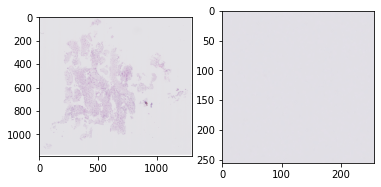

<Figure size 1440x720 with 0 Axes>

In [7]:
source = '/home/mahnaz/icaird-weaklysupervisedlearning/data/'
save_dir = '/home/mahnaz/icaird-weaklysupervisedlearning/notebooks/results'
mask_save_dir = os.path.join(save_dir, 'masks')
patch_save_dir = os.path.join(save_dir, 'patches')
stitch_save_dir = os.path.join(save_dir, 'stitches')


Path(mask_save_dir).mkdir(parents=True, exist_ok=True)
Path(patch_save_dir).mkdir(parents=True, exist_ok=True)
Path(stitch_save_dir).mkdir(parents=True, exist_ok=True)

seg_params = {'seg_level': -1, 'sthresh': 10, 'mthresh':7, 'close': 4, 'use_otsu': False,
                                  'keep_ids': 'none', 'exclude_ids': 'none'}
filter_params = {'a_t':100, 'a_h': 16, 'max_n_holes':20}
vis_params = {'vis_level': -1, 'line_thickness': 250}
patch_params = {'use_padding': True, 'contour_fn': 'four_pt'}

slides = sorted(os.listdir(source))
slides = [slide for slide in slides if 'isyntax' in slide and os.path.isfile(os.path.join(source, slide))]
s_time = time.time()
for slide in slides:
    slide_id, _ = os.path.splitext(slide)
    full_path = os.path.join(source, slide)
    WSI_object = WholeSlideImage(full_path)
    
    img_lvl = len( WSI_object.level_dimensions) -1
    if vis_params['vis_level'] < 0:
            if len(WSI_object.level_dimensions) == 1:
                 vis_params['vis_level'] = 0
                    
            else:   
                best_level = get_best_level_for_downsample(64)
                if best_level > img_lvl:
                    vis_params['vis_level'] = img_lvl
                else:
                    vis_params['vis_level'] = best_level
    # If slide is scanned at just one zoom level, set the segmetation level to zero, else to level 6
    if seg_params['seg_level'] < 0:
        if len(WSI_object.level_dimensions) == 1:
            seg_params['seg_level'] = 0
                    
        else:
            best_level = get_best_level_for_downsample(64)
            if best_level > img_lvl:
                seg_params['seg_level'] = img_lvl
            else:
                seg_params['seg_level'] = best_level
    print('Image is scanned at level = {} and will be segmented at level = {} and visualised at level = {}'
                  .format(img_lvl, seg_params['seg_level'],vis_params['vis_level']))
    
    # Calculate the dimension of the WSI at level we want to segment it and if it is too large abort the segmentation
    dim = WSI_object.level_dimensions[int(seg_params['seg_level'])]
    w = dim[1]-dim[0] + 1
    h = dim[3]-dim[2] + 1
    if w * h > 1e8:
        print('level_dim {} x {} is likely too large for successful segmentation, aborting'.format(w, h))
        df.loc[idx, 'status'] = 'failed_seg'
        continue
                    
    seg_time_elapsed = -1
    WSI_object, seg_time_elapsed = segment(WSI_object, seg_params, filter_params) 
    mask = WSI_object.visWSI(**vis_params)
    
    mask_path = os.path.join(mask_save_dir, slide_id+'.jpg')
    mask.save(mask_path)  
    seg_time = time.time()-s_time
    print('{}, seg_time:{} '.format(slide, seg_time))
            
    #display the msak
    #plt.imshow(mask)
            
    #patch the slide
    patch_time_elapsed = -1
    file_path, patch_time_elapsed = patching(patch_save_dir,  WSI_object, **patch_params)
    print("patching took {} seconds\n".format(patch_time_elapsed))

    #stitching
    stitch_time_elasped = -1
    file_path = os.path.join(patch_save_dir, slide_id+'.h5')
    heatmap, stitch_time_elapsed = stitching(file_path, downscale= 64)
    stitch_path = os.path.join(stitch_save_dir, slide_id+'.png')
    fig2 = plt.figure(figsize = (20,10))
    #plt.imshow(heatmap)
    heatmap.save(stitch_path)
    print("stitching took {} seconds".format(stitch_time_elapsed))


            